In this second assignment, you are challenged to employ Hugging Face transformers for the same classification task as in the first assignment.

You should explore Hugging Face models to find a pre-trained model that is suitable and promising for fine-tuning with data for the ADU type classification task. It should make sense to pick one that has been pre-trained with Portuguese (either in isolation or in a multi-lingual fashion), possibly with data from a similar genre.

As a bonus, you can also employ a domain adaptation approach, by leveraging on the full text of opinion articles made available.

You should compare the performance of your model(s) with the ones developed for the first assignment. For the final delivery, prepare a short presentation (max 10 slides) documenting your approach.



## Loading the dataset 

In [ ]:
%ls

sample_data/


In [1]:
!pip install datasets
!pip install transformers
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 346 kB 4.8 MB/s 
     |████████████████████████████████| 86 kB 7.2 MB/s 
     |████████████████████████████████| 140 kB 71.3 MB/s 
     |████████████████████████████████| 212 kB 63.0 MB/s 
     |████████████████████████████████| 86 kB 4.7 MB/s 
     |████████████████████████████████| 1.1 MB 65.6 MB/s 
     |████████████████████████████████| 596 kB 59.0 MB/s 
     |████████████████████████████████| 127 kB 73.3 MB/s 
     |████████████████████████████████| 94 kB 4.2 MB/s 
     |████████████████████████████████| 271 kB 76.1 MB/s 
     |████████████████████████████████| 144 kB 76.6 MB/s 
     |████████████████████████████████| 112 kB 66.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing ins

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import pandas as pd

dataset = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/data/OpArticles_ADUs.xlsx")
translated_dataset = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/translated_spans.csv")
dataset.head()

,article_id,annotator,node,ranges,tokens,label
0,5d04a31b896a7fea069ef06f,A,0,"[[2516, 2556]]",O facto não é apenas fruto da ignorância,Value
1,5d04a31b896a7fea069ef06f,A,1,"[[2568, 2806]]",havia no seu humor mais jornalismo (mais inves...,Value
2,5d04a31b896a7fea069ef06f,A,3,"[[3169, 3190]]",É tudo cómico na FIFA,Value
3,5d04a31b896a7fea069ef06f,A,4,"[[3198, 3285]]",o que todos nós permitimos que esta organizaçã...,Value
4,5d04a31b896a7fea069ef06f,A,6,"[[4257, 4296]]",não nos fazem rir à custa dos poderosos,Value


## Data cleaning

Some text spans were annotated more than once. In these cases, there are 2 possibilities:


1.   The text span is kept, if all annotations consider that the example belongs to the same class; 
2.   The text span is eliminated, if different annotators assign different labels to the example. 



In [8]:
import numpy as np

grouped_df = dataset.groupby(by=['article_id', 'ranges'])
dataset_dict = {"tokens": [], "label": [], "article_id": []}

for i, group in grouped_df:
    dict_counts = {x: group["label"].value_counts()[x] for x in np.unique(group[['label']].values)}
    if len(dict_counts.keys()) > 1:
        continue
    dataset_dict["article_id"].append(group["article_id"].values[0])
    dataset_dict["tokens"].append(group["tokens"].values[0])
    dataset_dict["label"].append(list(dict_counts.keys())[0])
    
dataset = pd.DataFrame(dataset_dict, columns = ["tokens", "label", "article_id"])
dataset.head()

,tokens,label,article_id
0,presumo que essas partilhas tenham gerado um e...,Value,5cdd971b896a7fea062d6e3d
1,essas partilhas tenham gerado um efeito bola d...,Value,5cdd971b896a7fea062d6e3d
2,esta questão ter [justificadamente] despertado...,Value,5cdd971b896a7fea062d6e3d
3,a ocasião propicia um debate amplo na sociedad...,Value,5cdd971b896a7fea062d6e3d
4,a tomada urgente de medidas por parte da tutel...,Value,5cdd971b896a7fea062d6e3d


In [14]:
counts = dataset["label"].value_counts()

The dataset is now ready for splitting. Without any augmentation, it contains roughly 10.000 samples. Similarly to assignment 1, it is unbalanced, having significantly more "Value" examples.

In order to easily use and split the dataset, we need to convert it into a Hugging Face dataset.

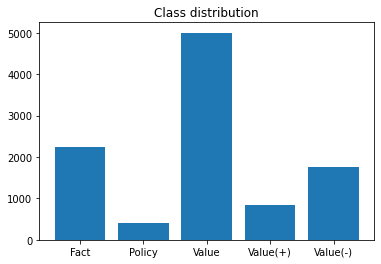

In [16]:
import matplotlib.pyplot as plt
import seaborn as sb


labels, counts = np.unique(dataset["label"], return_counts=True)
plt.bar(labels, counts, align='center')
plt.title("Class distribution")
plt.savefig("/content/drive/MyDrive/Colab Notebooks/statistics/class_distribution.png")

In [6]:
from datasets import Dataset

labels = ['Value','Fact','Value(+)','Value(-)','Policy']
numeric_labels = []

for label in dataset["label"]:
    new_label = labels.index(label)
    numeric_labels.append(new_label)

dataset["label"] = numeric_labels
dataset["tokens"] = translated_dataset["Translated Spans"]
dataset_hf = Dataset.from_pandas(dataset)
dataset

,tokens,label,article_id
0,I assume these shares have generated a snowbal...,0,5cdd971b896a7fea062d6e3d
1,These shares have generated a snowball effect,0,5cdd971b896a7fea062d6e3d
2,This issue has [justifiably] the public's atte...,0,5cdd971b896a7fea062d6e3d
3,The occasion provides a broad debate in civil ...,0,5cdd971b896a7fea062d6e3d
4,The urgent taking of measurements by the guard...,0,5cdd971b896a7fea062d6e3d
...,...,...,...
10248,A mayor may belong to the administration of a ...,0,5d04c671896a7fea06a11275
10249,ethically it is reprehensible,3,5d04c671896a7fea06a11275
10250,ethically is reprehensible and common sense ad...,0,5d04c671896a7fea06a11275
10251,common sense advises not to do so,0,5d04c671896a7fea06a11275


## Splitting the dataset

We can now split the dataset into training, testing and validating sets.

In [17]:
from datasets import DatasetDict

# 90% train, 10% test+validation
train_test = dataset_hf.train_test_split(test_size=0.1)

# Split the 10% test+validation set in half test, half validation
valid_test = train_test['test'].train_test_split(test_size=0.5)

# gather everyone if you want to have a single DatasetDict
train_valid_test_dataset = DatasetDict({
    'train': train_test['train'],
    'validation': valid_test['train'],
    'test': valid_test['test']
})

BERTimbau Base is a pretrained BERT model for Brazilian Portuguese that achieves state-of-the-art performances on three downstream NLP tasks: Named Entity Recognition, Sentence Textual Similarity and Recognizing Textual Entailment. It is available in two sizes: Base and Large.

In [18]:
from transformers import AutoTokenizer  # Or BertTokenizer
from transformers import AutoModelForPreTraining  # Or BertForPreTraining for loading pretraining heads
from transformers import AutoModel  # or BertModel, for BERT without pretraining heads
from transformers import AutoModelForSequenceClassification

from transformers import TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
from datasets import load_metric
import numpy as np

metric = load_metric("accuracy")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)



# training_args = TrainingArguments("test_trainer", num_train_epochs=1)


def load_train(model_name, tokenizer_name):
  
  model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)
  tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, do_lower_case=False, padding=True, truncation=True, model_max_len=512)


  
  def preprocess_function(sample):
    return tokenizer(sample["tokens"], truncation=True, padding=True)

  tokenized_dataset = train_valid_test_dataset.map(preprocess_function, batched=True)

  training_args = TrainingArguments(
    output_dir=model_name,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
  )


  data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


  trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
  )
  return trainer


## Bert-base-uncased

In [19]:
trainer = load_train("bert-base-uncased", "bert-base-uncased")
trainer.train()
trainer.save_model()

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: article_id, tokens. If article_id, tokens are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9227
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1731


Epoch,Training Loss,Validation Loss,Accuracy
1,1.129600,0.952098,0.621832
2,0.853300,0.944856,0.627680
3,0.698600,1.005294,0.594542


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: article_id, tokens. If article_id, tokens are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 513
  Batch size = 16
Saving model checkpoint to bert-base-uncased/checkpoint-577
Configuration saved in bert-base-uncased/checkpoint-577/config.json
Model weights saved in bert-base-uncased/checkpoint-577/pytorch_model.bin
tokenizer config file saved in bert-base-uncased/checkpoint-577/tokenizer_config.json
Special tokens file saved in bert-base-uncased/checkpoint-577/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: article_id, tokens. If article_id, tokens are not expected by `BertForSequenceClassification.forward`,  you can safely ignor

In [20]:
import torch
from transformers import TextClassificationPipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def metrics(model_name):
  
  tokenizer2 = AutoTokenizer.from_pretrained(model_name)
  model2 = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)
  pipe = TextClassificationPipeline(model=model2, tokenizer=tokenizer2)

  def preprocess_function(sample):
    return tokenizer2(sample["tokens"], truncation=True, padding=True)

  tokenized_dataset = train_valid_test_dataset.map(preprocess_function, batched=True)

  y_pred= []
  for p in tokenized_dataset['test']['tokens']:
      ti = tokenizer2(p, return_tensors="pt")
      out = model2(**ti)
      pred = torch.argmax(out.logits)
      y_pred.append(pred.item())



  y_test = tokenized_dataset['test']['label']

  #print(confusion_matrix(y_test, y_pred))
  print('Accuracy: ', accuracy_score(y_test, y_pred))
  print('Precision: ', precision_score(y_test, y_pred, average='macro'))
  print('Recall: ', recall_score(y_test, y_pred, average='macro'))
  print('F1: ', f1_score(y_test, y_pred, average='macro'))

  cm = confusion_matrix(y_test, y_pred, labels = [0,1,2,3,4])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot()

Saving model checkpoint to bert-base-uncased
Configuration saved in bert-base-uncased/config.json
Model weights saved in bert-base-uncased/pytorch_model.bin
tokenizer config file saved in bert-base-uncased/tokenizer_config.json
Special tokens file saved in bert-base-uncased/special_tokens_map.json
Didn't find file bert-base-uncased/added_tokens.json. We won't load it.
loading file bert-base-uncased/vocab.txt
loading file bert-base-uncased/tokenizer.json
loading file None
loading file bert-base-uncased/special_tokens_map.json
loading file bert-base-uncased/tokenizer_config.json
loading configuration file bert-base-uncased/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Accuracy:  0.5984405458089669
Precision:  0.575098858256753
Recall:  0.5919064203513023
F1:  0.5748084076089799


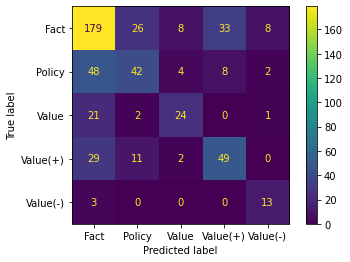

In [21]:
trainer.save_model()
metrics("bert-base-uncased")

## Bert-base-cased

In [22]:
trainer = load_train("bert-base-cased", "bert-base-cased")
trainer.train()
trainer.save_model()

https://huggingface.co/bert-base-cased/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpkhih3204


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

storing https://huggingface.co/bert-base-cased/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
creating metadata file for /root/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

storing https://huggingface.co/bert-base-cased/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/092cc582560fc3833e556b3f833695c26343cb54b7e88cd02d40821462a74999.1f48cab6c959fc6c360d22bea39d06959e90f5b002e77e836d2da45464875cda
creating metadata file for /root/.cache/huggingface/transformers/092cc582560fc3833e556b3f833695c26343cb54b7e88cd02d40821462a74999.1f48cab6c959fc6c360d22bea39d06959e90f5b002e77e836d2da45464875cda
loading weights file https://huggingface.co/bert-base-cased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/092cc582560fc3833e556b3f833695c26343cb54b7e88cd02d40821462a74999.1f48cab6c959fc6c360d22bea39d06959e90f5b002e77e836d2da45464875cda
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictio

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

storing https://huggingface.co/bert-base-cased/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/ec84e86ee39bfe112543192cf981deebf7e6cbe8c91b8f7f8f63c9be44366158.ec5c189f89475aac7d8cbd243960a0655cfadc3d0474da8ff2ed0bf1699c2a5f
creating metadata file for /root/.cache/huggingface/transformers/ec84e86ee39bfe112543192cf981deebf7e6cbe8c91b8f7f8f63c9be44366158.ec5c189f89475aac7d8cbd243960a0655cfadc3d0474da8ff2ed0bf1699c2a5f
loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,


Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

storing https://huggingface.co/bert-base-cased/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/6508e60ab3c1200bffa26c95f4b58ac6b6d95fba4db1f195f632fa3cd7bc64cc.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791
creating metadata file for /root/.cache/huggingface/transformers/6508e60ab3c1200bffa26c95f4b58ac6b6d95fba4db1f195f632fa3cd7bc64cc.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791
https://huggingface.co/bert-base-cased/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpd44_3ifo


Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

storing https://huggingface.co/bert-base-cased/resolve/main/tokenizer.json in cache at /root/.cache/huggingface/transformers/226a307193a9f4344264cdc76a12988448a25345ba172f2c7421f3b6810fddad.3dab63143af66769bbb35e3811f75f7e16b2320e12b7935e216bd6159ce6d9a6
creating metadata file for /root/.cache/huggingface/transformers/226a307193a9f4344264cdc76a12988448a25345ba172f2c7421f3b6810fddad.3dab63143af66769bbb35e3811f75f7e16b2320e12b7935e216bd6159ce6d9a6
loading file https://huggingface.co/bert-base-cased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/6508e60ab3c1200bffa26c95f4b58ac6b6d95fba4db1f195f632fa3cd7bc64cc.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791
loading file https://huggingface.co/bert-base-cased/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/226a307193a9f4344264cdc76a12988448a25345ba172f2c7421f3b6810fddad.3dab63143af66769bbb35e3811f75f7e16b2320e12b7935e216bd6159ce6d9a6
loading file https://huggingfac

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: article_id, tokens. If article_id, tokens are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9227
  Num Epochs = 3
  Instantaneous batch size per device = 16
 

Epoch,Training Loss,Validation Loss,Accuracy
1,1.093800,0.939261,0.627680
2,0.806900,0.959797,0.600390
3,0.628500,1.027063,0.621832


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: article_id, tokens. If article_id, tokens are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 513
  Batch size = 16
Saving model checkpoint to bert-base-cased/checkpoint-577
Configuration saved in bert-base-cased/checkpoint-577/config.json
Model weights saved in bert-base-cased/checkpoint-577/pytorch_model.bin
tokenizer config file saved in bert-base-cased/checkpoint-577/tokenizer_config.json
Special tokens file saved in bert-base-cased/checkpoint-577/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: article_id, tokens. If article_id, tokens are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this mes

Didn't find file bert-base-cased/added_tokens.json. We won't load it.
loading file bert-base-cased/vocab.txt
loading file bert-base-cased/tokenizer.json
loading file None
loading file bert-base-cased/special_tokens_map.json
loading file bert-base-cased/tokenizer_config.json
loading configuration file bert-base-cased/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type":

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Accuracy:  0.5730994152046783
Precision:  0.5434017594736764
Recall:  0.5222718554411468
F1:  0.5191770229049382


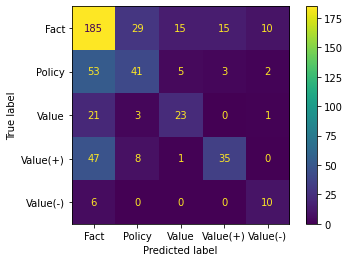

In [23]:
metrics("bert-base-cased")

## DistillBert-base-uncased




In [24]:
trainer = load_train("distilbert-base-uncased", "distilbert-base-uncased")
trainer.train()
trainer.save_model()

https://huggingface.co/distilbert-base-uncased/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp2qnc5zr2


Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

storing https://huggingface.co/distilbert-base-uncased/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
creating metadata file for /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

storing https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
creating metadata file for /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias',

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

storing https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/8c8624b8ac8aa99c60c912161f8332de003484428c47906d7ff7eb7f73eecdbb.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
creating metadata file for /root/.cache/huggingface/transformers/8c8624b8ac8aa99c60c912161f8332de003484428c47906d7ff7eb7f73eecdbb.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_r

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

storing https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10c3c92122b827d92eb2d34ce94ee79ba486c.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
creating metadata file for /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10c3c92122b827d92eb2d34ce94ee79ba486c.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpgzkynf_m


Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

storing https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer.json in cache at /root/.cache/huggingface/transformers/75abb59d7a06f4f640158a9bfcde005264e59e8d566781ab1415b139d2e4c603.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4
creating metadata file for /root/.cache/huggingface/transformers/75abb59d7a06f4f640158a9bfcde005264e59e8d566781ab1415b139d2e4c603.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10c3c92122b827d92eb2d34ce94ee79ba486c.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/75abb59d7a06f4f640158a9bfcde005264e59e8d566781ab1415b139d2e4c603.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4
loading

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: article_id, tokens. If article_id, tokens are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9227
  Num Epochs = 3
  Instantaneous batch size per d

Epoch,Training Loss,Validation Loss,Accuracy
1,1.133700,0.983149,0.612086
2,0.893000,0.960128,0.619883
3,0.775200,0.980827,0.623782


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: article_id, tokens. If article_id, tokens are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 513
  Batch size = 16
Saving model checkpoint to distilbert-base-uncased/checkpoint-577
Configuration saved in distilbert-base-uncased/checkpoint-577/config.json
Model weights saved in distilbert-base-uncased/checkpoint-577/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased/checkpoint-577/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased/checkpoint-577/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: article_id, tokens. If article_id, tokens are not expected by `DistilBertFor

Didn't find file distilbert-base-uncased/added_tokens.json. We won't load it.
loading file distilbert-base-uncased/vocab.txt
loading file distilbert-base-uncased/tokenizer.json
loading file None
loading file distilbert-base-uncased/special_tokens_map.json
loading file distilbert-base-uncased/tokenizer_config.json
loading configuration file distilbert-base-uncased/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Accuracy:  0.571150097465887
Precision:  0.536187498804588
Recall:  0.5311110149692827
F1:  0.525729411941527


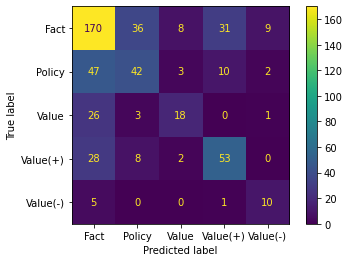

In [25]:
metrics("distilbert-base-uncased")

## Bert models pre-trained with 

In [28]:

trainer = load_train("roberta-base", "roberta-base")
trainer.train()
trainer.save_model()

https://huggingface.co/roberta-base/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpn743mo5t


Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

storing https://huggingface.co/roberta-base/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
creating metadata file for /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hid

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

storing https://huggingface.co/roberta-base/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/51ba668f7ff34e7cdfa9561e8361747738113878850a7d717dbc69de8683aaad.c7efaa30a0d80b2958b876969faa180e485944a849deee4ad482332de65365a7
creating metadata file for /root/.cache/huggingface/transformers/51ba668f7ff34e7cdfa9561e8361747738113878850a7d717dbc69de8683aaad.c7efaa30a0d80b2958b876969faa180e485944a849deee4ad482332de65365a7
loading weights file https://huggingface.co/roberta-base/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/51ba668f7ff34e7cdfa9561e8361747738113878850a7d717dbc69de8683aaad.c7efaa30a0d80b2958b876969faa180e485944a849deee4ad482332de65365a7
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_n

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

storing https://huggingface.co/roberta-base/resolve/main/vocab.json in cache at /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
creating metadata file for /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
https://huggingface.co/roberta-base/resolve/main/merges.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpfopo2dzb


Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

storing https://huggingface.co/roberta-base/resolve/main/merges.txt in cache at /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
creating metadata file for /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
https://huggingface.co/roberta-base/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpth2_qp76


Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

storing https://huggingface.co/roberta-base/resolve/main/tokenizer.json in cache at /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730
creating metadata file for /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730
loading file https://huggingface.co/roberta-base/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/roberta-base/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/roberta

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: article_id, tokens. If article_id, tokens are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9227
  Num Epochs = 3
  Instantaneous batch size per device 

Epoch,Training Loss,Validation Loss,Accuracy
1,1.114500,0.966586,0.619883
2,0.847800,0.967700,0.590643
3,0.729400,0.976116,0.612086


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: article_id, tokens. If article_id, tokens are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 513
  Batch size = 16
Saving model checkpoint to roberta-base/checkpoint-577
Configuration saved in roberta-base/checkpoint-577/config.json
Model weights saved in roberta-base/checkpoint-577/pytorch_model.bin
tokenizer config file saved in roberta-base/checkpoint-577/tokenizer_config.json
Special tokens file saved in roberta-base/checkpoint-577/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: article_id, tokens. If article_id, tokens are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this messag

Didn't find file roberta-base/added_tokens.json. We won't load it.
loading file roberta-base/vocab.json
loading file roberta-base/merges.txt
loading file roberta-base/tokenizer.json
loading file None
loading file roberta-base/special_tokens_map.json
loading file roberta-base/tokenizer_config.json
loading configuration file roberta-base/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "layer_norm_eps": 1e-05,
  "max_position_emb

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Accuracy:  0.5730994152046783
Precision:  0.5525273028432434
Recall:  0.5341690461769202
F1:  0.5366391914683168


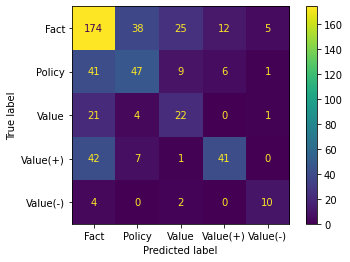

In [29]:
metrics("roberta-base")